In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from graph_tool.all import *
from graph_tool.draw import *

import heapq
import requests
import json
import time

In [2]:
def hex_to_int(id):
    '''Map patent id (string) to graph id (int).'''
    return int(id, 16)

def int_to_hex(id):
    '''Map graph id (int) to patent id (string).'''
    return '{0:0x}'.format(id)

## 5. Statistics on the graph

In this section, we take a look at how we can access elements of the patent graph and show some of its statistics. We will also compute some shortest paths between important patents and show that we can handle the size of the graph.

In [3]:
DATA = './data/'
graph = load_graph(DATA + 'citations_graph.xml.gz')
graph

<Graph object, directed, with 8274991 vertices and 86284396 edges at 0x7f9f5932f630>

The graph can be loaded in approximately 5 minutes.

### 5.1 Working with the graph

In this section we list useful functions that facilitate working with the graph:

In [25]:
# Extracting the properties of the graph vertices and getting the transformed patent id back:
x = graph.vp.id['12345']
int_to_hex(x)

'8828082'

In [26]:
# To extract a node with a given graph vertex index:
v = graph.vertex(12345)
v

<Vertex object with index '12345' at 0x7f9f592a48d0>

In [27]:
# Method 1 of retrieving the graph index of a given vertex
graph.vertex_index[v]

12345

In [28]:
# Method 2 of retrieving the graph index of a given vertex
int(v)

12345

In [29]:
# To extract an edge with given graph vertex indices
graph.edge(0,1)

<Edge object with source '0' and target '1' at 0x7f9f5920d468>

### 5.2 Graph overview

Our final directed graph comprises over 8 million nodes that are connected with over 85 million edges!

In [30]:
vertices = [int(v) for v in graph.vertices()]
print('Number of vertices:', graph.num_vertices())
print('Number of edges', graph.num_edges())

Number of vertices: 8274991
Number of edges 86284396


At first glance, it would be assumed that a patents graph is acyclic, since cycles would mean that there is a violation of temporal causality (patents cite future patents). However, using the *graph-tool* function *is_DAG*, we find out that, contrary to our assumptions, the directed graph is cyclic. A reason for this could be that patents cite patent applications that then become granted patents in the future. Another possible reason could be human mistakes. We will investigate this fact further.

In [31]:
# Is this graph a Directed Acyclic Graph?
is_DAG(graph)

False

### 5.3 Vertex in- and out-degrees

To get a sense of how connected our graph is, we calculate the in-degree (number of ingoing edges) and the out-degree (number of outgoing edges) for every node. The average in-degree should equal the average out-degree, since every edge has to have a source and target node.

Additionally, we list the top 10 patents of largest in- and out-degrees.

#### By in-degree

In [32]:
# Getting the in-degree of each vertex
in_deg = graph.get_in_degrees(vertices)

In [33]:
# Average in-degree
in_deg.mean()

10.427128682073491

In [34]:
# Median in-degree
np.median(in_deg)

3.0

In [35]:
# Listing the top 10 nodes by in-degree

max_in_degs = heapq.nlargest(10, enumerate(in_deg), key=lambda x: x[1])

print("Top 10 patents of largest in-degree:\n")
for idx, deg in enumerate(max_in_degs):
    patent_id = int_to_hex(graph.vp.id[deg[0]])
    patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
    patent_info = requests.get(patent_URL).json()
    patent_title = patent_info['patents'][0]['patent_title']
    
    print('Nr {}:\t{}'.format(idx+1, patent_title))
    print('\tDegree = {}, Patent ID = {}\n'.format(deg[1], patent_id))

Top 10 patents of largest in-degree:

Nr 1:	Process for amplifying nucleic acid sequences
	Degree = 3709, Patent ID = 4683202

Nr 2:	Mutant dwarfism gene of petunia
	Degree = 3342, Patent ID = 5523520

Nr 3:	Process for amplifying, detecting, and/or-cloning nucleic acid sequences
	Degree = 3188, Patent ID = 4683195

Nr 4:	Expandable intraluminal graft, and method and apparatus for implanting an expandable intraluminal graft
	Degree = 2697, Patent ID = 4733665

Nr 5:	Systems and methods for secure transaction management and electronic rights protection
	Degree = 2451, Patent ID = 5892900

Nr 6:	Methods for forming liquid crystal displays including thin film transistors and gate pads having a particular structure
	Degree = 2377, Patent ID = 5731856

Nr 7:	Semiconductor device and manufacturing method thereof
	Degree = 2367, Patent ID = 7674650

Nr 8:	Natural-superlattice homologous single crystal thin film, method for preparation thereof, and device using said single crystal thin film
	D

#### By out-degree

In [36]:
# Getting out-degrees of each vertex
out_deg = graph.get_out_degrees(vertices)

In [37]:
# Average out-degree (should be the same as average in-degree)
out_deg.mean()

10.427128682073491

In [38]:
# Median out-degree
np.median(out_deg)

4.0

In [39]:
# Listing the top 10 nodes by out-degree

max_out_degs = heapq.nlargest(10, enumerate(out_deg), key=lambda x: x[1])

print("Top 10 vertices of largest out-degree:\n")
for idx, deg in enumerate(max_out_degs):
    patent_id = int_to_hex(graph.vp.id[deg[0]])
    patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
    patent_info = requests.get(patent_URL).json()
    patent_title = patent_info['patents'][0]['patent_title']
    
    print('Nr {}:\t{}'.format(idx+1, patent_title))
    print('\tDegree = {}, Patent ID = {}\n'.format(deg[1], patent_id))

Top 10 vertices of largest out-degree:

Nr 1:	Internet appliance system and method
	Degree = 5832, Patent ID = 9535563

Nr 2:	Adaptive pattern recognition based controller apparatus and method and human-interface therefore
	Degree = 5819, Patent ID = 8892495

Nr 3:	Alarm system controller and a method for controlling an alarm system
	Degree = 3032, Patent ID = 8369967

Nr 4:	System, method and computer program product for a collaborative decision platform
	Degree = 2880, Patent ID = 8160988

Nr 5:	System, method and computer program product for a collaborative decision platform
	Degree = 2844, Patent ID = 8005777

Nr 6:	System, method and computer program product for a collaborative decision platform
	Degree = 2823, Patent ID = 7970722

Nr 7:	Staple cartridge comprising an implantable layer
	Degree = 2681, Patent ID = 9724098

Nr 8:	Adjunct with integrated sensors to quantify tissue compression
	Degree = 2679, Patent ID = 9724094

Nr 9:	Firing member retraction devices for powered surg

#### Histogram of vertices by in-degree

To visually assess how the number of vertices per in-degree are distributed, we decided to plot both histograms where the y axis is scaled normally and using a log-scale, as well as a log-log plot. 

If the distribution of in-degrees was exponential, we would see a straight line in the second plot, whereas if it was distributed according to a power law, we would observe a straight line in the log-log plot. Neither are the case and therefore we do not observe a power law. This means that patents that have been cited only a few times are very common, whereas highly cited patents are rare.

In [40]:
vhist_in = vertex_hist(graph, 'in')

<function matplotlib.pyplot.show>

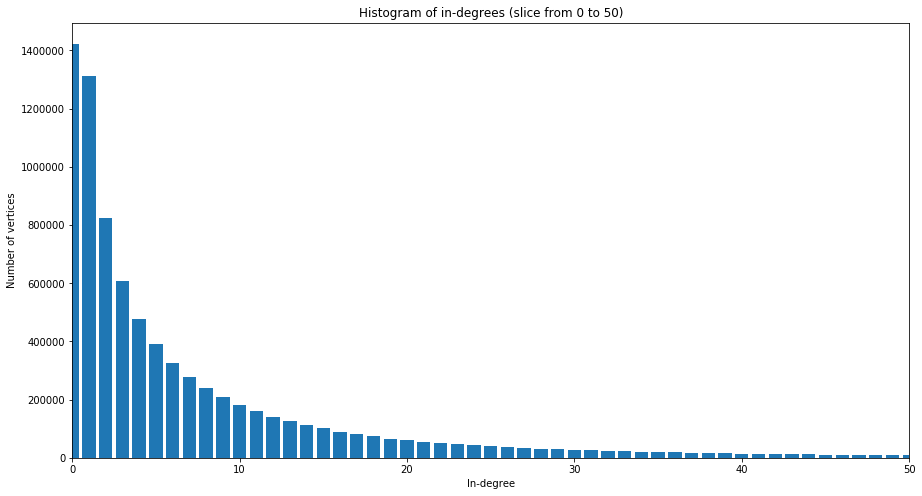

In [54]:
plt.figure(1, figsize=(15, 8))
plt.title('Histogram of in-degrees (slice from 0 to 50)')
plt.bar(vhist_in[1][:-1], vhist_in[0])
plt.xlim((0,50))
plt.xlabel('In-degree')
plt.ylabel('Number of vertices')
plt.show

<function matplotlib.pyplot.show>

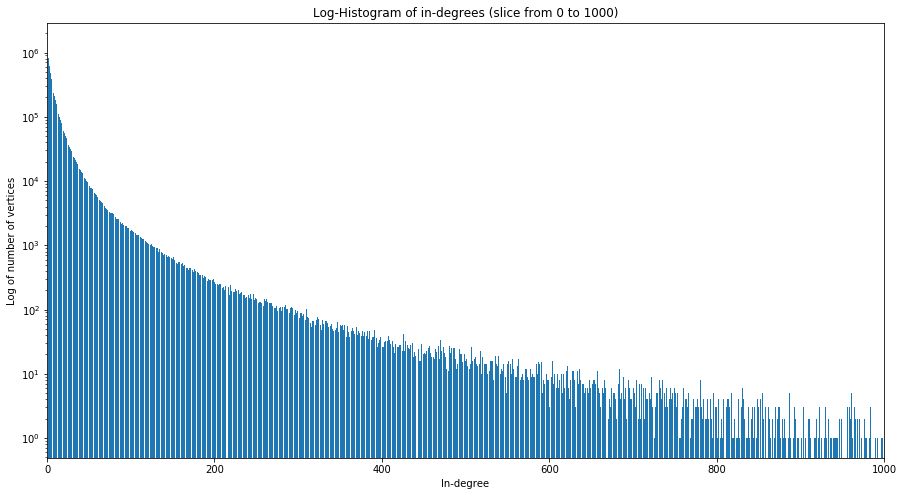

In [53]:
plt.figure(1, figsize=(15, 8))
plt.title('Log-Histogram of in-degrees (slice from 0 to 1000)')
plt.bar(vhist_in[1][:-1], vhist_in[0], log=True)
plt.xlim((0,1000))
plt.xlabel('In-degree')
plt.ylabel('Log of number of vertices')
plt.show

<function matplotlib.pyplot.show>

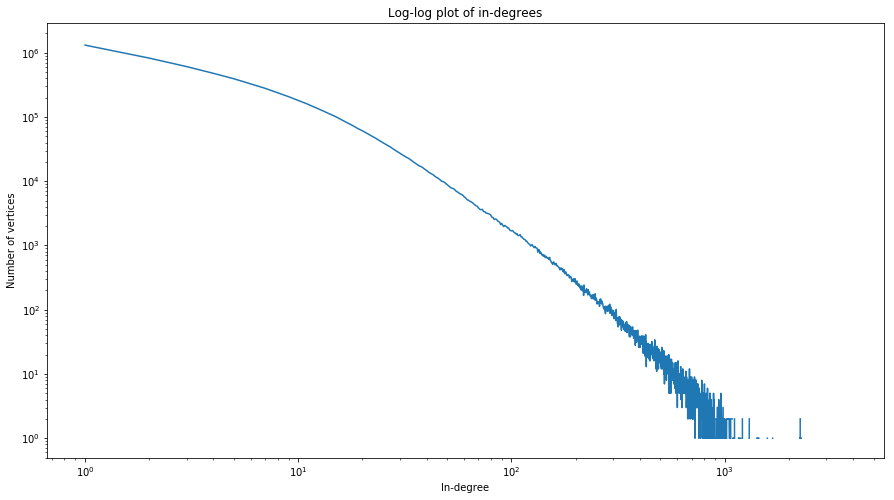

In [43]:
plt.figure(1, figsize=(15, 8))
plt.title('Log-log plot of in-degrees')
plt.loglog(vhist_in[1][:-1], vhist_in[0])
plt.xlabel('In-degree')
plt.ylabel('Number of vertices')
plt.show

#### Histogram of vertices by out-degree

Like before, we plot both histograms where the y axis is scaled normally and using a log-scale, as well as a log-log plot of the number of vertices per out-degree.

In the first plot, it becomes clear that roughly one third of all patents in our graph did not cite other patents. Most of them are patents that were issued before 1976, for which we do not have more data available in our data sets. We also observe a spike in the beginning, meaning that citing 3 or 4 patents is most common.

If it was distributed according to a power law, we would observe a straight line in the log-log plot. For out-degrees between 0 and 10, we do not observe such a straight line, but from 10 upwards it becomes apparent that there must be a power law. This means that patents citing many other patents is not uncommon.

In [45]:
vhist_out = vertex_hist(graph, 'out')

<function matplotlib.pyplot.show>

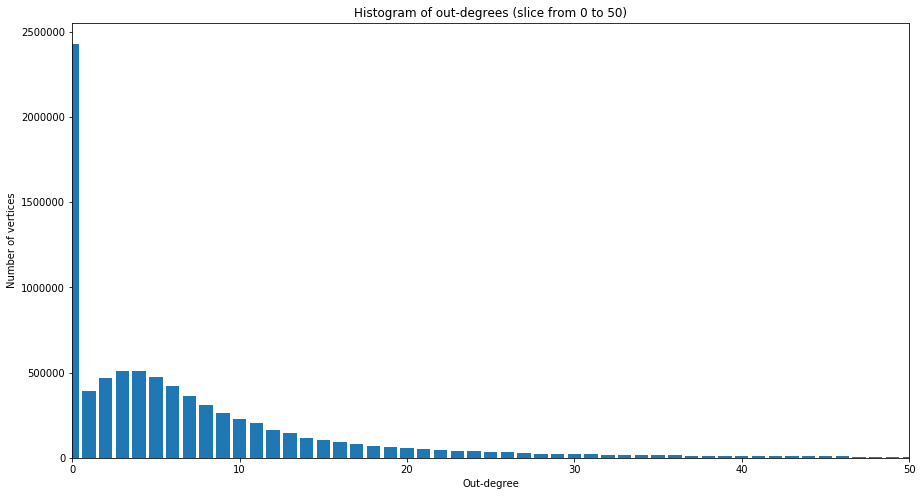

In [55]:
plt.figure(1, figsize=(15, 8))
plt.title('Histogram of out-degrees (slice from 0 to 50)')
plt.bar(vhist_out[1][:-1], vhist_out[0])
plt.xlim((0,50))
plt.xlabel('Out-degree')
plt.ylabel('Number of vertices')
plt.show

<function matplotlib.pyplot.show>

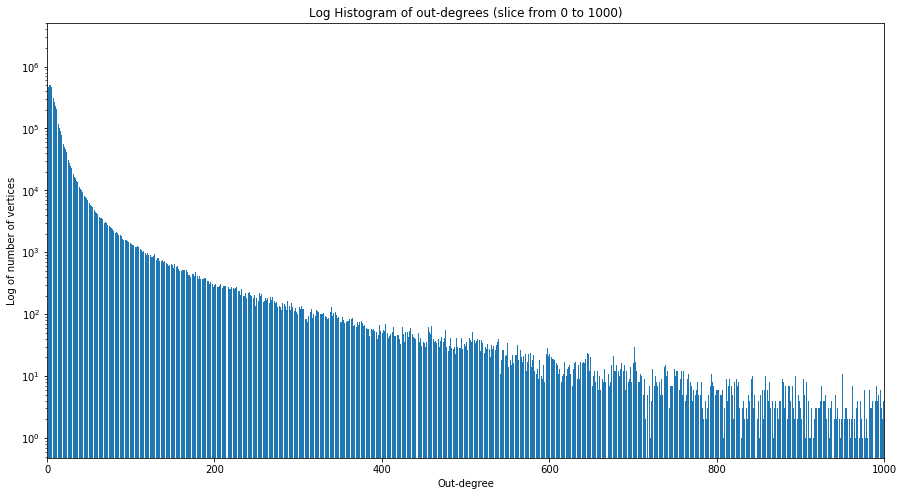

In [47]:
plt.figure(1, figsize=(15, 8))
plt.title('Log Histogram of out-degrees (slice from 0 to 1000)')
plt.bar(vhist_out[1][:-1], vhist_out[0], log=True)
plt.xlim((0,1000))
plt.xlabel('Out-degree')
plt.ylabel('Log of number of vertices')
plt.show

<function matplotlib.pyplot.show>

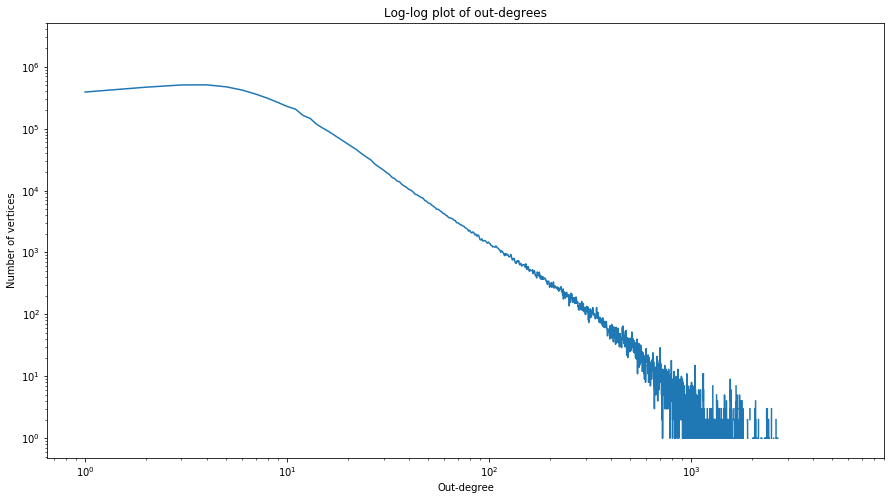

In [48]:
plt.figure(1, figsize=(15, 8))
plt.title('Log-log plot of out-degrees')
plt.loglog(vhist_out[1][:-1], vhist_out[0])
plt.xlabel('Out-degree')
plt.ylabel('Number of vertices')
plt.show

### 5.4 Shortest path between selected nodes

One of the central premises of our project idea was to find out how connected the patents in the graph actually are. One important step for this goal is to see if there even exists any path between two important patents of our choice and how short this path can be. We therefore compute the shortest path and print it out if it exists. Below, some examples of this pipeline are listed.

Some interesting patent ids:

- Google page rank: 6285999
- Snapchat Augmented Reality: 9652896
- Dropbox Network folder synchronization: 8825597
- Facebook Dynamically generating a privacy summary: 8225376
- SolarCity Methods for financing renewable energy systems: 7904382
- GoPro Harness system for attaching camera to user: 6955484
- Apple Microcomputer for use with video display 4136359
- Semiconductor: 2981877

In [52]:
def list_shortest_path(source, target, graph, verbose=False):
    '''Compute and print the shortest path between two patents.
    This function will pull the patent titles from the patentsview.org api.
    
    Keyword arguments:
    source -- Patent id of source node (string)
    target -- Patent id of target node (string)
    graph -- Patent graph
    verbose -- Set to true to print out shortest path (default=False)
    '''
    
    source_int_id = hex_to_int(source)
    target_int_id = hex_to_int(target)
    
    source_vertex = find_vertex(graph, graph.vertex_properties.id, source_int_id)
    if (len(source_vertex) == 0):
        print('Source not found in graph.')
        return None
    
    target_vertex = find_vertex(graph, graph.vertex_properties.id, target_int_id)
    if (len(target_vertex) == 0):
        print('Target not found in graph.')
        return None
    
    path = shortest_path(graph, source_vertex[0], target_vertex[0])
    
    if (len(path[0]) == 0):
        print('The graph contains no path from source to target.')
        return None
    
    if verbose:
        print('Shortest path:\n--------------')
        for idx, v in enumerate(path[0]):
            patent_id = int_to_hex(graph.vp.id[int(v)])
            patent_URL = 'http://www.patentsview.org/api/patents/query?q={"patent_number":"' + patent_id + '"}'
            patent_info = requests.get(patent_URL).json()
            if (patent_info['patents'] is None):
                patent_title = '-No title available-'
            else:
                patent_title = patent_info['patents'][0]['patent_title']
            print('ID: {}\t{}'.format(patent_id, patent_title))
            if (idx < len(path[0])-1):
                print('↓')
            
    return path

In [50]:
# Shortest path between Snapchat Augmented Reality and Apple II patents
_ = list_shortest_path('9652896', '4136359', graph, verbose=True)

Shortest path:
--------------
ID: 9652896	Image based tracking in augmented reality systems
↓
ID: 9098926	Generating three-dimensional fa&#xe7;ade models from images
↓
ID: 7174039	System and method for embodying virtual reality
↓
ID: 6888552	High dynamic range image editing
↓
ID: 6396505	Methods and apparatus for detecting and reducing color errors in images
↓
ID: 4136359	Microcomputer for use with video display


In [51]:
# Shortest path between Google Page Rank and Semiconductor patents
_ = list_shortest_path('6285999', '2981877', graph, verbose=True)

Shortest path:
--------------
ID: 6285999	Method for node ranking in a linked database
↓
ID: 6014678	Apparatus for preparing a hyper-text document of pieces of information having reference relationships with each other
↓
ID: 5634062	System for managing hypertext node information and link information
↓
ID: 5446891	System for adjusting hypertext links with weighed user goals and activities
↓
ID: 5021976	Method and system for generating dynamic, interactive visual representations of information structures within a computer
↓
ID: 4752893	Graphics data processing apparatus having image operations with transparent color having a selectable number of bits
↓
ID: 4590463	Digital control of color in CRT display
↓
ID: 4276543	Monolithic triple diffusion analog to digital converter
↓
ID: 3981072	Bipolar transistor construction method
↓
ID: 2981877	-No title available-


### 5.5 Speed of complex graph algorithms

Searching the shortest path between two patents running in O(V+E):

In [11]:
source_int_id = hex_to_int('9652896')
target_int_id = hex_to_int('4136359')
source_vertex = find_vertex(graph, graph.vertex_properties.id, source_int_id)
target_vertex = find_vertex(graph, graph.vertex_properties.id, target_int_id)

t = time.process_time()
shortest_path(graph, source_vertex[0], target_vertex[0])
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Elapsed time: 0.1490846929999634 seconds


Calculating the histogram of vertex in-degrees running in O(V):

In [44]:
t = time.process_time()
vertex_hist(graph, 'in')
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Elapsed time: 0.23201369599996724 seconds


Calculating the minimum spanning tree running in O(E log E):

In [ ]:
t = time.process_time()
min_spanning_tree(graph)
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Calculating an iterator for all the cycles in the graph running in worse time O((V+E)\*(C+1)), where C is the number of cycles:

In [ ]:
t = time.process_time()
all_circuits(graph)
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

We tried running an O(V^2) algorithm (shortest-distance histogram for each vertex pair in the graph) but it did not finish in a reasonable amount of time. Assuming 8 Million vertices, V^2 is in the order of 6.4e+13, which would take days to compute. We will therefore not use algorithms of this complexity and resort to approximating our results by sampling a random (but not too small) subset of the graph. Below is a test of this function with a small sample size.

In [21]:
t = time.process_time()
dist_hist = distance_histogram(graph, samples=100)
elapsed_time = time.process_time() - t
print('Elapsed time:', elapsed_time, 'seconds')

Elapsed time: 52.870005959000025 seconds


<function matplotlib.pyplot.show>

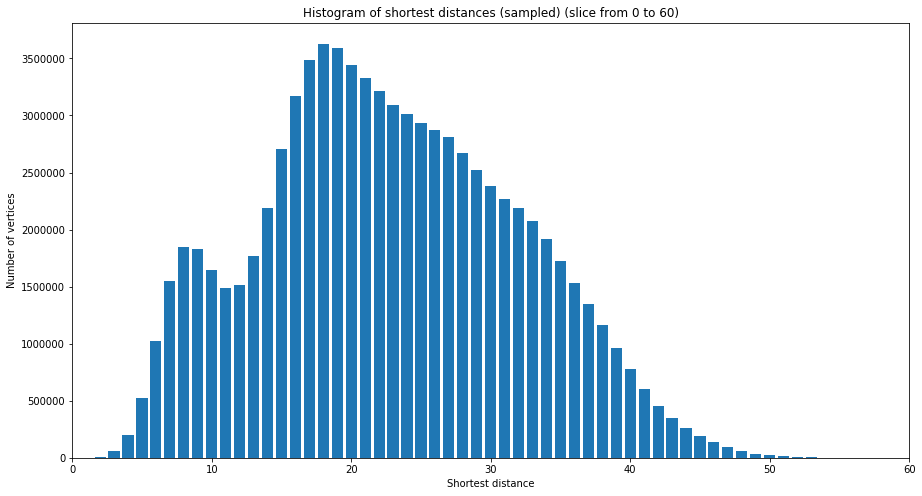

In [24]:
plt.figure(1, figsize=(15, 8))
plt.title('Histogram of shortest distances (sampled) (slice from 0 to 60)')
plt.bar(dist_hist[1][:-1], dist_hist[0])
plt.xlim((0,60))
plt.xlabel('Shortest distance')
plt.ylabel('Number of vertices')
plt.show